# Transfer Learning With Tensorflow Part 1: Feature Extraction

## What is transfer learning ?

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

- Can leverage an existing neural network architecture prove to work on problem similiar to our own
- Can leverage a working network architecture which has already learned patterns on similiar data to our own (often results in great results with less data)

Surely someone has spent the time crafting the right model for the job..

Example Transfer Learning use cases:

- Computer vision see: https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview
- Natural Language Proccessing

## What we're going to cover

- Introduce transfer lerning with tensorflow
- Using a small dataset experiment faster (10% of training samples)
- Building a transfer learning feature extraction model with tensorflow hub
- Use tensorboard to track modelling experiments and results

## Material

- see: http://github.com/mrdbourke/tensorflow-deep-learning/#course-materials


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Tue Nov 14 08:15:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8               4W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
STORAGE = os.path.join('..', 'storage')
IMAGE_PATH = f'{STORAGE}/images'
ZIP_PATH = f'{STORAGE}/zip'
MODEL_PATH = f'{STORAGE}/models'
TRANSFER_LEARNING_PATH = f'{STORAGE}/transfer_learning'

# concat paths
LIST_PATHS = [IMAGE_PATH, ZIP_PATH, MODEL_PATH, TRANSFER_LEARNING_PATH]

In [4]:
for dir in LIST_PATHS:
    if not os.path.exists(dir):
        os.mkdir(dir)

## Downloading and becoming one with the data

In [6]:
import zipfile
import urllib.request as ur
import shutil

filename = '10_food_classes_10_percent.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

if not os.path.exists(f'{ZIP_PATH}/{filename}'):
    # download zip file
    ur.urlretrieve(url, filename)
    shutil.move(filename, f'{ZIP_PATH}')

# unzip the download file
zip_ref = zipfile.ZipFile(f'{ZIP_PATH}/{filename}', 'r')

# remove folder if exist
folder = filename.split('.')[0]
if os.path.isdir(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    shutil.rmtree(f'{TRANSFER_LEARNING_PATH}/{folder}')

zip_ref.extractall(f'{TRANSFER_LEARNING_PATH}')
zip_ref.close()

In [7]:
# How many images in each folder
for dirpath, dirnames, filenames in os.walk(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    print(f'dir: {len(dirnames)} images: {len(filenames)} path: {dirpath}')

dir: 2 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent
dir: 10 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent\test
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_curry
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_wings
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\fried_rice
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\grilled_salmon
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\hamburger
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ice_cream
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\pizza
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ramen
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [8]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/test'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print(f'Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

print(f'Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Settings up callbacks (things to run whilist our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

- Tracking experiments with the Tensorboard callback
- Model checkpoint
- Early stopping a model from training (before it trains to long and overfits) with EarlyStopping Callbacks

In [9]:
# Create tensorflow callback (functionized beacause we need to create a new for each model)
def create_tensorflow_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir)
    
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorflow_callback

## create models using tensorflow hub

see: https://www.tensorflow.org/hub?hl=pt-br

In the past we've used Tensorflow to creae our own models layer by layer from scratch. Now we're going to do a similar process, execpt the majority of our model's layers are going to come from Tensorflow Hub.


- We can access pretrained models on: https://tfhub.dev
- We can see which the model has the better performance in: https://paperswithcode.com/task/image-classification


Browsing the Tensorflow hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [10]:
# Let's compare the following two models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [13]:
!pip install tensorflow_hub

   ---------------------------------------- 85.4/85.4 kB 4.7 MB/s eta 0:00:00


In [11]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

In [12]:
# let's make a create a model function to create a model from URL
def create_model(model_url, num_classes=10):
    """
        Takes a Tensorflow Hub URL and creates a keras Sequential model with it.

        Args:
            model_url (str): A Tensorflow Hub feature extraction HRL.
            num_classes (int): Number of output classes neurons in the output layer
                                shoould be equal to number of target classes, default 10

        Returns:
            An uncompiled Keas Sequential model with model_url as feature extractor layer and Dense output layer with nm_classes out neurons.
    """

    # Download the pretrained mode and save it as Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False,
                                             name='feature_extractor_layer',
                                             input_shape=IMAGE_SHAPE+(3,)) # freeze the already learned patterns
    
    # create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

In [13]:
# create a resnet tensorflow hub feature extraction model
resnet_model = create_model(resnet_url, train_data_10_percent.num_classes)

In [14]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [15]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [16]:
# let fit the model our resnet to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                    validation_steps=len(test_data_10_percent),
                                  callbacks=[
                                      create_tensorflow_callback(dir_name=f"{TRANSFER_LEARNING_PATH}/tensorflow_hub", 
                                                                 experiment_name="resnet50v2")])

Saving TensorBoard log files to: ..\storage/transfer_learning/tensorflow_hub/resnet50v2/20231115-093229
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.9869 - accuracy: 0.3347 - val_loss: 1.2331 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 14s 600ms/step - loss: 0.9025 - accuracy: 0.7333 - val_loss: 0.8667 - val_accuracy: 0.7152
Epoch 3/5
24/24 [==============================] - 14s 621ms/step - loss: 0.6191 - accuracy: 0.8267 - val_loss: 0.7523 - val_accuracy: 0.7464
Epoch 4/5
24/24 [==============================] - 14s 612ms/step - loss: 0.4650 - accuracy: 0.8800 - val_loss: 0.7021 - val_accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 14s 615ms/step - loss: 0.3718 - accuracy: 0.9280 - val_loss: 0.6713 - val_accuracy: 0.7764


Wow!

That. Is. Incredible. our transfer learning feature extractor model our performed all of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the traning examples.

In [24]:
# let's create a function to plot our loss curves
# tidit: you could put a function like this into script called 'helper' and import
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
        Separete loss curves for training and validation metrics

        Args:
            History: Tensorflow History Object
        
        Returns:
            Plots of training validation loss and accuracy metrics.
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs= range(len(history.history['loss']))
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

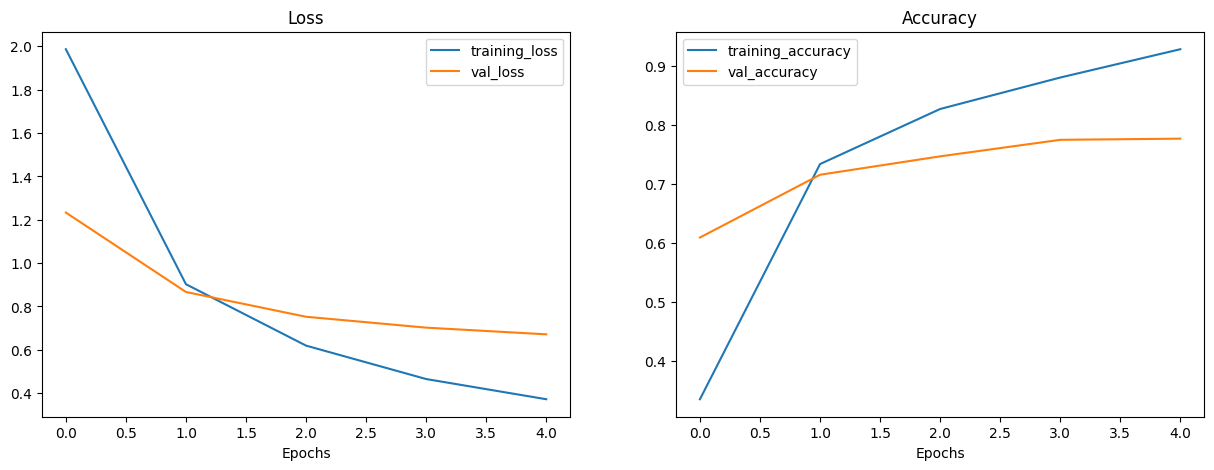

In [25]:
plot_loss_curves(resnet_history)

In [26]:
# create a efficientnet
efficientnet_model = create_model(efficientnet_url, train_data_10_percent.num_classes)

In [27]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [28]:
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [29]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorflow_callback(dir_name=f'{TRANSFER_LEARNING_PATH}/tensorflow_hub', 
                                                                                    experiment_name='efficientnet50v2')])

Saving TensorBoard log files to: ..\storage/transfer_learning/tensorflow_hub/efficientnet50v2/20231115-115040
Epoch 1/5
24/24 [==============================] - 26s 603ms/step - loss: 1.8174 - accuracy: 0.4533 - val_loss: 1.2917 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 10s 439ms/step - loss: 1.0491 - accuracy: 0.7747 - val_loss: 0.8609 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 12s 497ms/step - loss: 0.7488 - accuracy: 0.8333 - val_loss: 0.6937 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 12s 523ms/step - loss: 0.6023 - accuracy: 0.8693 - val_loss: 0.6081 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 11s 451ms/step - loss: 0.5121 - accuracy: 0.8907 - val_loss: 0.5535 - val_accuracy: 0.8588


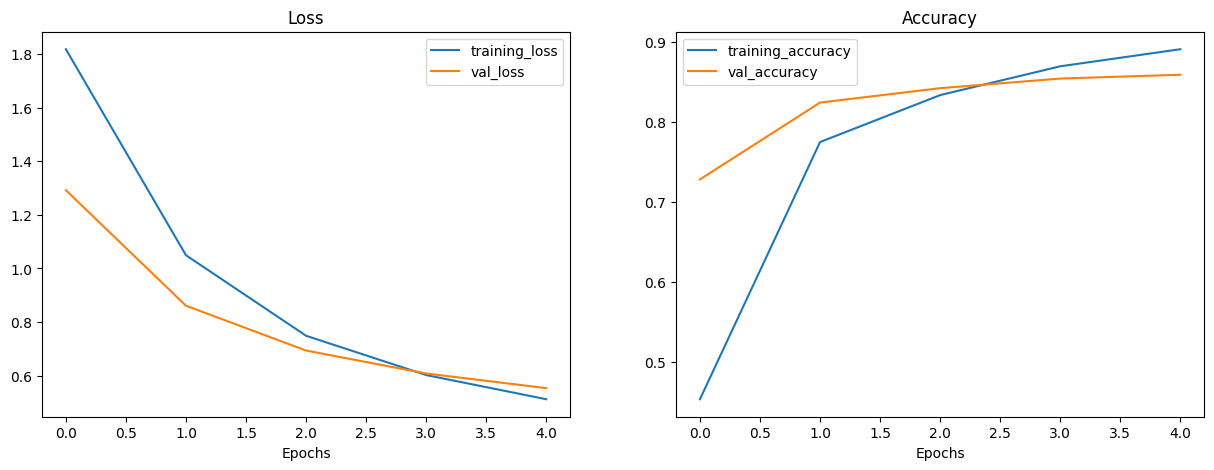

In [30]:
plot_loss_curves(efficientnet_history)